                              Logit Regression Results                             
Dep. Variable:     RSAW remission criteria   No. Observations:                   78
Model:                               Logit   Df Residuals:                       72
Method:                                MLE   Df Model:                            5
Date:                     Thu, 01 May 2025   Pseudo R-squ.:                  0.1650
Time:                             09:09:48   Log-Likelihood:                -42.519
converged:                            True   LL-Null:                       -50.920
Covariance Type:                 nonrobust   LLR p-value:                  0.004891
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             1.8385      1.683      1.093      0.275      -1.460       5.136
Age                              -

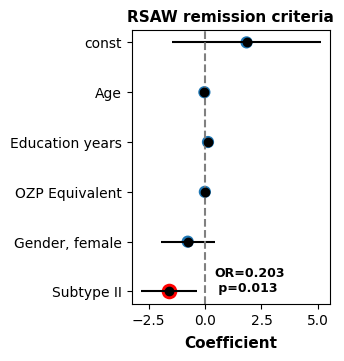

Odds Ratios and Confidence Intervals for RSAW remission criteria:
                       OR      2.5%     97.5%
const            6.286911 -1.459531  5.136471
Age              0.970013 -0.094666  0.033774
Education years  1.138122 -0.043634  0.302393
OZP Equivalent   0.989950 -0.091723  0.071522
Gender, female   0.463570 -1.960541  0.422944
Subtype II       0.202589 -2.856606 -0.336549


In [3]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 读取数据
df = pd.read_excel('data.xlsx')


def fit_logistic_regression(df, group_column, control_vars):
    # 过滤数据，提取Label中0和1
    df_filtered = df[df['Label'].isin([0, 1])].copy()

    # 转换Group变量（缓解为1，未缓解为0）
    df_filtered[group_column] = df_filtered[group_column].map({1: 1, 2: 0})

    # 将亚组（Label）作为自变量
    df_filtered['Subgroup'] = df_filtered['Label']

    # 对分类变量生成哑变量，包括亚组变量
    df_filtered = pd.get_dummies(df_filtered, columns=['Gender', 'Subgroup'], drop_first=True)

    # 自变量（包括 Dose Equivalent to Olanzapine）
    X = df_filtered[[col for col in df_filtered.columns if col in control_vars or col.startswith(('Gender_', 'Subgroup_'))]]

    # 因变量
    y = df_filtered[group_column]

    # 添加常数项
    X = sm.add_constant(X)

    # 拟合逻辑回归模型
    model = sm.Logit(y, X)
    result = model.fit(disp=False)

    # 输出模型摘要
    print(result.summary())

    # 计算系数、置信区间和 OR
    coef = result.params
    conf = result.conf_int()
    conf['coef'] = coef
    conf.columns = ['2.5%', '97.5%', 'coef']
    odds_ratios = np.exp(result.params)
    conf['OR'] = odds_ratios

    return conf, result


def plot_combined_coefficients(conf_list, labels, annotations, suptitle):
    # 创建变量名映射字典
    variable_names = {
        'Education_years': 'Education years',
        'Gender_2': 'Gender, female',
        'Subgroup_1': 'Subtype II',
        'Dose Equivalent to Olanzapine': 'OZP Equivalent'
    }
    
    # 以第一个模型的变量名称为准构建Y轴标签
    y_labels = [variable_names.get(var, var) for var in conf_list[0].index]
    
    # 创建子图 - 1行1列布局，共享X轴
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 4.2), sharex=True)

    conf = conf_list[0]
    conf.index = y_labels

    # 绘制点图
    sns.pointplot(x='coef', y=conf.index, data=conf.reset_index().rename(columns={'index':'var'}),
                  join=False, markers='o', ax=ax)
    ax.errorbar(
        x=conf['coef'],
        y=np.arange(len(conf.index)),
        xerr=[conf['coef'] - conf['2.5%'], conf['97.5%'] - conf['coef']],
        fmt='o',
        color='black'
    )
    ax.axvline(0, color='gray', linestyle='--')
    
    # 高亮并注释 Subtype 变量
    for i, var in enumerate(conf.index):
        if 'Subtype' in var:
            ci_lower, ci_upper = conf.loc[var, '2.5%'], conf.loc[var, '97.5%']
            color = 'red' if ci_lower > 0 or ci_upper < 0 else 'green'
            ax.scatter(conf.loc[var, 'coef'], i, color=color, s=150, edgecolor='white')
            if color == 'red':
                ax.text(
                    conf.loc[var, 'coef'] + 2,
                    i,
                    annotations[0],
                    fontsize=9,
                    fontweight='bold',
               
                )

    # 设置标题和标签
    ax.set_title(labels[0], fontsize=11, fontweight='bold')
    ax.set_xlabel('Coefficient', fontsize=11, fontweight='bold', labelpad=6)
    ax.set_ylabel('')

    # 添加总标题并调整位置
    fig.suptitle(suptitle, fontsize=14, fontweight='bold', x=0.5, y=1.3)

    plt.tight_layout(rect=[0, 0, 1, 0.92])

    # 保存并展示
    plt.savefig('combined_coef_plot.jpg', dpi=1200, bbox_inches='tight')
    plt.show()

# 定义需要控制的变量
control_vars = ['Age', 'Education_years', 'Gender', 'Dose Equivalent to Olanzapine']

# 计算 RSAW remission criteria 的 logistic 回归模型系数
conf1, result1 = fit_logistic_regression(df, 'RSAW remission criteria', control_vars)

# 定义注释内容
annotations = [
    'OR=0.203\n p=0.013',  # RSAW 的注释
]

# 绘制组合图
plot_combined_coefficients(
    [conf1],
    ['RSAW remission criteria'],
    annotations,
    suptitle=''
)

# 打印 Odds Ratios 和 置信区间
print("Odds Ratios and Confidence Intervals for RSAW remission criteria:")
print(conf1[['OR', '2.5%', '97.5%']])


                           Logit Regression Results                           
Dep. Variable:     PANSS duction 0.25   No. Observations:                   78
Model:                          Logit   Df Residuals:                       72
Method:                           MLE   Df Model:                            5
Date:                Thu, 01 May 2025   Pseudo R-squ.:                 0.07055
Time:                        09:09:49   Log-Likelihood:                -36.787
converged:                       True   LL-Null:                       -39.580
Covariance Type:            nonrobust   LLR p-value:                    0.3488
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             2.2715      1.826      1.244      0.213      -1.307       5.850
Age                              -0.0089      0.035     -0.253      0.800 

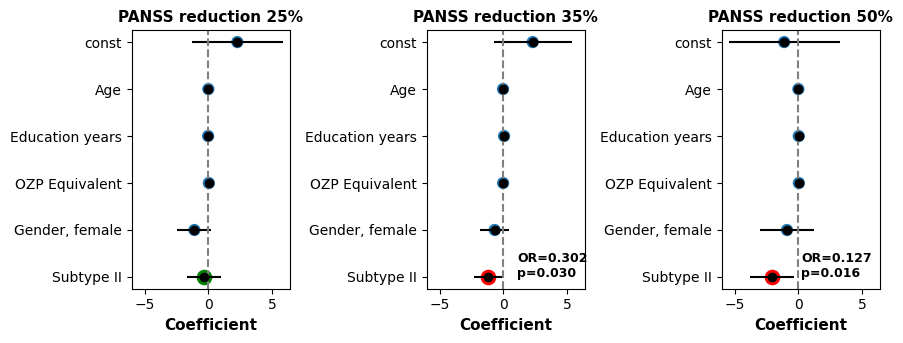

Odds Ratios and Confidence Intervals for PANSS reduction 25%:
                       OR      2.5%     97.5%
const            9.694368 -1.306874  5.849964
Age              0.991159 -0.077589  0.059828
Education years  0.973270 -0.184912  0.130726
OZP Equivalent   1.029150 -0.068342  0.125809
Gender, female   0.330315 -2.448499  0.233083
Subtype II       0.706896 -1.702230  1.008486

Odds Ratios and Confidence Intervals for PANSS reduction 35%:
                       OR      2.5%     97.5%
const            9.974503 -0.755172  5.355237
Age              0.965666 -0.095145  0.025271
Education years  1.048300 -0.099077  0.193417
OZP Equivalent   0.972301 -0.108126  0.051946
Gender, female   0.500039 -1.836044  0.449906
Subtype II       0.301593 -2.281732 -0.115621

Odds Ratios and Confidence Intervals for PANSS reduction 50%:
                       OR      2.5%     97.5%
const            0.324323 -5.483060  3.231031
Age              0.992200 -0.094453  0.078790
Education years  1.022856 -0.1

In [4]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 读取数据
df = pd.read_excel('data.xlsx')


def fit_logistic_regression(df, group_column, control_vars):
    # 过滤数据，提取Label中0和1
    df_filtered = df[df['Label'].isin([0, 1])].copy()

    # 转换Group变量（缓解为1，未缓解为0）
    df_filtered[group_column] = df_filtered[group_column].map({1: 1, 2: 0})

    # 将亚组（Label）作为自变量
    df_filtered['Subgroup'] = df_filtered['Label']

    # 对分类变量生成哑变量，包括亚组变量
    df_filtered = pd.get_dummies(df_filtered, columns=['Gender', 'Subgroup'], drop_first=True)

    # 自变量（包括 Dose Equivalent to Olanzapine）
    X = df_filtered[[col for col in df_filtered.columns if col in control_vars or col.startswith(('Gender_', 'Subgroup_'))]]

    # 因变量
    y = df_filtered[group_column]

    # 添加常数项
    X = sm.add_constant(X)

    # 拟合逻辑回归模型
    model = sm.Logit(y, X)
    result = model.fit(disp=False)

    # 输出模型摘要
    print(result.summary())

    # 计算系数、置信区间和 OR
    coef = result.params
    conf = result.conf_int()
    conf['coef'] = coef
    conf.columns = ['2.5%', '97.5%', 'coef']
    odds_ratios = np.exp(result.params)
    conf['OR'] = odds_ratios

    return conf, result


def plot_combined_coefficients(conf_list, labels, annotations, suptitle):
    # 创建变量名映射字典
    variable_names = {
        'Education_years': 'Education years',
        'Gender_2': 'Gender, female',
        'Subgroup_1': 'Subtype II',
        'Dose Equivalent to Olanzapine': 'OZP Equivalent'
    }
    
    # 以第一个模型的变量名称为准构建Y轴标签
    y_labels = [variable_names.get(var, var) for var in conf_list[0].index]
    
    # 创建子图 - 1行3列布局，共享X轴
    fig, axes = plt.subplots(1, 3, figsize=(9, 4), sharex=True)

    for i, (conf, label, annotation) in enumerate(zip(conf_list, labels, annotations)):
        ax = axes[i]
        conf.index = y_labels

        # 绘制点图
        sns.pointplot(x='coef', y=conf.index, data=conf.reset_index().rename(columns={'index':'var'}),
                      join=False, markers='o', ax=ax)
        ax.errorbar(
            x=conf['coef'],
            y=np.arange(len(conf.index)),
            xerr=[conf['coef'] - conf['2.5%'], conf['97.5%'] - conf['coef']],
            fmt='o',
            color='black'
        )
        ax.axvline(0, color='gray', linestyle='--')
        ax.set_title(label, fontsize=11, fontweight='bold')
        ax.set_xlabel('Coefficient', fontsize=11, fontweight='bold')
        ax.set_ylabel('')

        # 高亮并注释 Subtype 变量
        for j, var in enumerate(conf.index):
            if 'Subtype' in var:
                ci_lower, ci_upper = conf.loc[var, '2.5%'], conf.loc[var, '97.5%']
                color = 'red' if ci_lower > 0 or ci_upper < 0 else 'green'
                ax.scatter(conf.loc[var, 'coef'], j, color=color, s=150, edgecolor='white')
                if color == 'red':
                    ax.text(
                        conf.loc[var, 'coef'] + 2.3,
                        j,
                        annotation,
                        fontsize=9,
                        fontweight='bold',
      
                    )

    # 添加总标题并调整位置
    fig.suptitle(suptitle, fontsize=14, fontweight='bold', x=0.5, y=1)
    plt.tight_layout(rect=[0, 0, 1, 0.92])

    # 保存并展示
    plt.savefig('combined_coef_plot-3.jpg', dpi=1200, bbox_inches='tight')
    plt.show()

# 定义需要控制的变量
control_vars = ['Age', 'Education_years', 'Gender', 'Dose Equivalent to Olanzapine']

# 计算三种 PANSS reduction 模型系数
conf2, result2 = fit_logistic_regression(df, 'PANSS duction 0.25', control_vars)
conf3, result3 = fit_logistic_regression(df, 'PANSS duction 0.35', control_vars)
conf4, result4 = fit_logistic_regression(df, 'PANSS duction 0.50', control_vars)

# 定义注释内容
annotations = [
    'OR=0.707\np=0.616',  # PANSS 25% 的注释
    'OR=0.302\np=0.030',  # PANSS 35% 的注释
    'OR=0.127\np=0.016'   # PANSS 50% 的注释
]

# 绘制组合图
plot_combined_coefficients(
    [conf2, conf3, conf4],
    ['PANSS reduction 25%', 'PANSS reduction 35%', 'PANSS reduction 50%'],
    annotations,
    suptitle=''
)

# 打印 Odds Ratios 和 置信区间
print("Odds Ratios and Confidence Intervals for PANSS reduction 25%:")
print(conf2[['OR', '2.5%', '97.5%']])
print("\nOdds Ratios and Confidence Intervals for PANSS reduction 35%:")
print(conf3[['OR', '2.5%', '97.5%']])
print("\nOdds Ratios and Confidence Intervals for PANSS reduction 50%:")
print(conf4[['OR', '2.5%', '97.5%']])
